<a href="https://colab.research.google.com/github/pranay8297/Harvard-Rare-Disease-Hackathon/blob/main/hrd_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep

In [3]:
!pip install pronto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00


In [4]:
import math
import pronto

In [3]:
pheno_ontology = pronto.Ontology('./hpo.obo')

<ipython-input-3-445b7bd13fd2>:1: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  pheno_ontology = pronto.Ontology('./hpo.obo')


In [4]:
hpo = pheno_ontology
pheno = hpo.get_term('HP:0000059')

In [5]:
def get_ancestors_up_to_root(ontology, start_term, stop_term='HP:0000118'):
    """
    :param ontology: pronto Ontology object (computed in function "load_ontology")
    :param start_term: specific HPO term (e.g., 'HP:0000164')
    :param stop_term: root term, known to be 'HP:0000118' (phenotypic abnormality)
    :return: set of all parent terms up to the root term
    """

    ancestors = set()
    current_term = ontology[start_term]

    for parent in current_term.superclasses():
        if parent.id == current_term.id: # first item is always the term itself
            continue
        if parent.id == stop_term:
            break
        ancestors.add(parent.id)

    return ancestors

In [6]:
def read_disease_annotations(hpo_disease_annotations):
    """
    :param hpo_disease_annotations: full path to the tab-delimited "phenotype.hpoa" file downloaded from HPO
    :return: dictionary from disease ID -> set of corresponding HPO terms AND dictionary from disease ID -> name
    """

    disease_to_hpo = {}
    disease_to_name = {}

    ontology = pronto.Ontology('./hpo.obo')

    with open(hpo_disease_annotations, 'r') as anno_handle:
        header = None
        for anno_line in anno_handle:

            if anno_line.startswith('#'):
                continue

            if not header:
                header = anno_line.strip().split('\t')
                continue

            disease_id, disease_name, _, hpo_id = anno_line.split('\t')[0:4]

            if disease_id not in disease_to_hpo:  # create dictionary of disease -> set (HPO terms)
                disease_to_hpo[disease_id] = set()
                disease_to_name[disease_id] = disease_name

            disease_to_hpo[disease_id].add(hpo_id)

            # get all parents and add it to the same disease
            parents = get_ancestors_up_to_root(ontology, hpo_id)
            for parent in parents:
                disease_to_hpo[disease_id].add(parent)

    # storing it as a json file here
    import json
    new_d = {}
    for k, v in disease_to_hpo.items():
        new_d[k] = list(v)
    with open('./disease_to_hpo.json', 'w') as fp:
        json.dump(new_d, fp)

    print("Number of diseases with annotations = " + str(len(disease_to_hpo.keys())))
    print("Average number terms/disease = " + str(
        sum([len(v) for v in disease_to_hpo.values()]) / len(disease_to_hpo.keys())))

    return disease_to_hpo, disease_to_name

In [ ]:
read_disease_annotations('/content/phenotype.hpoa')

In [8]:
import json
with open('/content/disease_to_hpo.json', 'r') as f:
    data = json.load(f)

In [9]:
max_len = 0
for i in data.values():
    if len(i) > max_len:
        max_len = len(i)
print(max_len)

602


# Tokenizer, Dataset and DataLoader

In [6]:
#
'''
X - Phenotypes
Y - Disease

Approach - Sample random phenotypes from X (30 pct)
Y - Disease

Model - Transformer
Sequential Data

X - already a list of phenotypes
Conver this X to Embeddings
1. Add a cls token embedding at the start
2. Pad them for the symptom length
No positional encoding

Model:

Transformer
1. Masked Attention Needs to be done and avoid all pad tokens
2. Multi head Attention

Loss Function: Cross Entropy Loss
Optimizer: AdamW


----

Model Initialization: Kaiming Init - Or, lets experiment - With random variances, the key that final activation should have
a standard normal distribution
'''

'\nX - Phenotypes\nY - Disease\n\nApproach - Sample random phenotypes from X (30 pct)\nY - Disease\n\nModel - Transformer\nSequential Data\n\nX - already a list of phenotypes\nConver this X to Embeddings\n1. Add a cls token embedding at the start\n2. Pad them for the symptom length\nNo positional encoding\n\nModel:\n\nTransformer\n1. Masked Attention Needs to be done and avoid all pad tokens\n2. Multi head Attention\n\nLoss Function: Cross Entropy Loss\nOptimizer: AdamW\n\n\n---- \n\nModel Initialization: Kaiming Init - Or, lets experiment - With random variances, the key that final activation should have \na standard normal distribution\n'

In [8]:
import torch
import pickle
import random
import json
import numpy as np

from einops import rearrange
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from matplotlib import pyplot as plt

In [9]:
class Tokenizer():
    def __init__(self, pheno_list, tokenizer_path = None, max_len = 256, save_path = None):

        if tokenizer_path:
            try:
                with open(tokenizer_path, 'rb') as f:
                    self = pickle.load(f)
                    return
            except:
                print('TOKENIZER NOT FOUND, INITIALIZING NEW ONE')

        self.key_value = {
            'CLS_KEY': 0,
            'PAD_KEY': 1,
            'UNK': 2
        }

        self.max_len = max_len
        self.phenotype_list = pheno_list
        for idx, pheno in enumerate(pheno_list):
            self.key_value[pheno] = idx + 3

        self.value_key = {v: k for k, v in self.key_value.items()}
        if save_path:
            self.save_tokenizer(save_path)

    def get_key(self, pheno):
        try:
            return self.key_value[pheno]
        except:
            return self.key_value['UNK']

    def save_tokenizer(self, tokenizer_path):
        print(f'SAVING TOKENIZER AT: {tokenizer_path}')
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(self, f)

    def _tokenize(self, pheno_list):
        return [self.key_value[pheno] if pheno in self.key_value else self.key_value['UNK'] for pheno in pheno_list]

    def pad(self, pheno_list):
        pheno_list = ['CLS_KEY'] + pheno_list
        delta = max(0, (self.max_len - len(pheno_list)))
        if len(pheno_list) < self.max_len:
            pheno_list += ['PAD_KEY'] * (self.max_len - len(pheno_list))
        else:
            pheno_list = pheno_list[:self.max_len]

        assert len(pheno_list) == self.max_len
        return pheno_list, delta

    def tokenize(self, pheno_list):
        # 2 things
        # 1. Tokenized Pheno List
        # 2. Pad Mask
        padded_pheno_list, n_padded = self.pad(pheno_list)
        tokenized_pheno_list = torch.tensor(self._tokenize(padded_pheno_list)).to(torch.long)
        pad_mask = torch.tensor([1] * (self.max_len - n_padded) + [0] * n_padded).to(torch.long)

        # Verification
        assert len(tokenized_pheno_list) == self.max_len
        assert len(pad_mask) == self.max_len

        return tokenized_pheno_list, pad_mask

    def reverse_tokenize(self, tokenized_pheno_list):
        return [self.value_key[token] for token in tokenized_pheno_list]

In [19]:
with open('/content/disease_to_hpo.json', 'r') as f:
    data = json.load(f)

values = []
for i in data.values():
    values.extend(i)
pheno_list = list(set(values))

In [23]:
tokenizer = Tokenizer(pheno_list, max_len = 256, save_path = '/content/tokenizer.pkl')
# tokenizer = Tokenizer(pheno_list, tokenizer_path = '/content/tokenizer.pkl')

SAVING TOKENIZER AT: /content/tokenizer.pkl


In [24]:
x = list(data.values())[0]
len(x)

60

In [10]:
import random

class DS(Dataset):
    def __init__(self, data_dict, tokenizer, save_path = None):
        self.data = data_dict

        self.X = list(data_dict.values())
        self.Y = list(data_dict.keys())
        self.Y_values = {y: i for i, y in enumerate(self.Y)}
        self.tokenizer = tokenizer

        if save_path:
            self.save_dataset(save_path)

    def save_dataset(self, save_path):
        print(f'SAVING DATASET AT: {save_path}')
        with open(save_path, 'wb') as f:
            pickle.dump(self, f)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]

        if len(x) > self.tokenizer.max_len:
            # sample tokenizer.max_len number of items out of this list randomly
            sampled_indices = random.sample(range(len(x)), self.tokenizer.max_len)
            x = [x[i] for i in sampled_indices]

        elif len(x) < self.tokenizer.max_len:
            # sample somewhere between 30% to 70% of x randomly
            sample_percentage = random.uniform(0.2, 0.99)
            sample_size = max(1, int(len(x) * sample_percentage))
            sampled_indices = random.sample(range(len(x)), sample_size)
            x = [x[i] for i in sampled_indices]

        tokens, mask = self.tokenizer.tokenize(x)
        return (tokens, mask), self.Y_values[y]

In [27]:
dataset = DS(data, tokenizer)
# with open('/content/dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [28]:
# YAY Dataset is working and verified
(tokens, mask), disease = dataset[0]

In [23]:
# Saving the Dataset
with open('/content/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [78]:
iter_data = iter(dataloader)
x, y = next(iter_data)

In [104]:
x[0].shape, x[1].shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64]))

In [89]:
len(tokenizer.key_value)

12508

# Lets Write the Transformer MANNNNN!!!!!!

In [13]:
def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        # Initialize linear and embedding weights with Kaiming initialization
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm)):
        # Initialize normalization layer parameters
        if module.weight is not None:
            nn.init.ones_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class MultiHeadAttention(nn.Module): # Verified

    def __init__(self, d_model, nhead):

        super().__init__()
        assert d_model % nhead == 0

        self.kqv = nn.Linear(d_model, 3*d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.nhead = nhead

    def forward(self, x, attention_mask):

        # x -> (b, s, e) -> (b s, h, e/h)
        kqv = self.kqv(x) # (b, s, 3*d_model)
        k, q, v = torch.chunk(kqv, 3, dim = -1) # (3, b, s, d_model)

        k = rearrange(k, 'b s (h e) -> b h s e', h = self.nhead)
        q = rearrange(q, 'b s (h e) -> b h s e', h = self.nhead)
        v = rearrange(v, 'b s (h e) -> b h s e', h = self.nhead)

        # Attention claculation - # TODO: make is_casual true in case of finetuning - Very important
        y = F.scaled_dot_product_attention(q, k, v, attn_mask = attention_mask[:, None, None, :], is_causal = False) # flash attention
        y = rearrange(y, 'b h s e -> b s (h e)', h = self.nhead)

        return self.proj(y)

class MLP(nn.Module):
    def __init__(self, d_model):
        super(MLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(approximate = 'tanh'),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, x):
        return self.layer(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        # Self Attn
        # MLP
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)
        self.mlp = MLP(d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        attn = self.self_attn(x, mask)
        x = self.norm1(x + attn)
        mlp_out = self.mlp(x)
        x = self.norm2(x + mlp_out)
        return x

class Net(nn.Module):
    def __init__(self, vocab_size, emb_dim = 512, n_classes = 12687, n_layers = 8, n_heads = 16):

        super(Net, self).__init__()

        self.n_classes = n_classes
        self.n_layers = n_layers
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)
        self.transformers = nn.ModuleList([EncoderLayer(d_model = emb_dim, nhead = n_heads) for _ in range(n_layers)])
        self.classifier = nn.Linear(emb_dim, n_classes)

    def forward(self, x, mask):
        # breakpoint()
        x = self.embedding(x) # (b, s, e)
        x = self.norm(x) # (b, s, e)
        mask = mask.bool()
        for transformer in self.transformers:
            x = transformer(x, mask)

        x = x[:, 0, :].squeeze() # (b, s, e) -> (b, e)
        x = self.classifier(x) # (b, e) -> (b, num_classes)
        return x

In [26]:
model = Net(len(tokenizer.key_value), n_layers = 8)
model = model.apply(init_weights)

In [131]:
tokens, mask = x[0], x[1]
logits = model(tokens, mask)

In [142]:
y.shape, y.dtype, logits.shape

(torch.Size([64]), torch.int64, torch.Size([64, 12687]))

In [150]:

loss_fn = nn.CrossEntropyLoss()
opt = AdamW(model.parameters(), lr = max_lr, weight_decay = 1e-02)

for i in range(10):
    opt.zero_grad()
    logits = model(tokens, mask)
    loss = loss_fn(logits, y)
    loss.backward()
    opt.step()
    print(loss.item())

10.484833717346191
8.209488868713379
6.239413738250732
4.530508518218994
3.043102264404297
1.8216582536697388
0.9548807144165039
0.435703307390213
0.1810034066438675
0.07764700055122375


In [144]:
loss

tensor(9.7035, grad_fn=<NllLossBackward0>)

In [28]:
len(dataloader)

199

# Training the initial model

In [32]:
model = None
del model
import gc
gc.collect()
torch.cuda.empty_cache()

In [33]:
import numpy as np

epochs = 100

dataloader = DataLoader(dataset, batch_size = 192, shuffle = True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(len(tokenizer.key_value), n_layers = 6)
model = model.apply(init_weights)
model = model.to(device)

max_lr = 5e-04
loss_fn = nn.CrossEntropyLoss()

opt = AdamW(model.parameters(), lr = max_lr, weight_decay = 1e-02)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,
                                                   max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(dataloader),
                                                   pct_start=0.1,
                                                   anneal_strategy='cos',
                                                   cycle_momentum=True,
                                                   base_momentum=0.85,
                                                   max_momentum=0.95,
                                                   div_factor=100.0,
                                                   final_div_factor=1000,
                                                   last_epoch=-1)

# variances = np.linspace(0.05, 0.15, epochs)
train_losses = []
for epoch in range(epochs):
    train_iter = iter(dataloader)
    for it, (x, y) in enumerate(train_iter):

        tokens, mask = x[0].to(device), x[1].to(device)
        y = y.to(torch.long).to(device)

        logits = model(tokens, mask)
        loss = loss_fn(logits, y)

        train_losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

    print(f"Epoch: {epoch} | Train Loss: {np.mean(train_losses[-len(dataloader):]):.4f}")
    if epoch % 5 == 0: # do checkpointing
        # PLS FINISH THE CODE
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'loss': np.mean(train_losses[-len(dataloader):])
        }
        torch.save(checkpoint, f'/content/drive/MyDrive/hrd_hack/model_checkpoint_epoch_{epoch}.pt')
        print(f"Checkpoint saved at epoch {epoch}")


Epoch: 0 | Train Loss: 10.4448
Checkpoint saved at epoch 0
Epoch: 1 | Train Loss: 10.2200
Epoch: 2 | Train Loss: 10.0366
Epoch: 3 | Train Loss: 9.9041
Epoch: 4 | Train Loss: 9.8188
Epoch: 5 | Train Loss: 9.7992
Checkpoint saved at epoch 5
Epoch: 6 | Train Loss: 9.7700
Epoch: 7 | Train Loss: 9.6116
Epoch: 8 | Train Loss: 9.2823
Epoch: 9 | Train Loss: 8.8428
Epoch: 10 | Train Loss: 8.3100
Checkpoint saved at epoch 10
Epoch: 11 | Train Loss: 7.7741
Epoch: 12 | Train Loss: 7.2526
Epoch: 13 | Train Loss: 6.8192
Epoch: 14 | Train Loss: 6.3889
Epoch: 15 | Train Loss: 6.0309
Checkpoint saved at epoch 15
Epoch: 16 | Train Loss: 5.6587
Epoch: 17 | Train Loss: 5.3335
Epoch: 18 | Train Loss: 5.0220
Epoch: 19 | Train Loss: 4.7063
Epoch: 20 | Train Loss: 4.4632
Checkpoint saved at epoch 20
Epoch: 21 | Train Loss: 4.1345
Epoch: 22 | Train Loss: 3.8826
Epoch: 23 | Train Loss: 3.6099
Epoch: 24 | Train Loss: 3.3966
Epoch: 25 | Train Loss: 3.1438
Checkpoint saved at epoch 25
Epoch: 26 | Train Loss: 2.913

In [35]:
checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'loss': np.mean(train_losses[-len(dataloader):])
        }
torch.save(checkpoint, f'/content/drive/MyDrive/hrd_hack/model_checkpoint_epoch_{epoch}.pt')
print(f"Checkpoint saved at epoch {epoch}")

Checkpoint saved at epoch 99


In [37]:
dataset[2]

((tensor([    0,  1288,  8984, 11900,  9595,  8750,  5646,  5271,  9969, 10099,
           7065,  8349, 11069,  3479,  3452,  7142,  6165, 11255,  8534,  7776,
           6539,  1662,  7641,  7987,  4184, 11609,  2916,  4622,  9258,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

In [38]:
with open('./drive/MyDrive/hrd_hack/ds_test.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [42]:
tokenizer.max_len

256

In [43]:
with open('./drive/MyDrive/hrd_hack/tokenizer_test.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [39]:
with open('./drive/MyDrive/hrd_hack/ds_test.pkl', 'rb') as f:
    dataset_test = pickle.load(f)

In [40]:
dataset_test[2]

((tensor([    0,  7776, 11609,  5271,  6539,  8984,  8647, 10099,  2916,  7142,
          11255,  5646,  8750,  1662,  9967,  9969,  1288, 11900,  6165,  8349,
           7065,  8534,  3452,  7641,  9595,  9258,  7987,  4184, 11069,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

In [45]:
with open('./drive/MyDrive/hrd_hack/tokenizer_test.pkl', 'rb') as f:
    tokenizer_test = pickle.load(f)
tokenizer_test.max_len

256

# Lets Create DISEASE Embeddings

In [ ]:
# step 1 calculate IC scores for each of the phenotype
# for each disease - create a hpo_id_token array and also create a IC score array
# Multiply, add and divide by sum of IC Scores
# May be Normalize it and visualize

In [9]:
with open('./drive/MyDrive/hrd_hack/tokenizer_test.pkl', 'rb') as f:
    tokenizer_test = pickle.load(f)
tokenizer_test.max_len


256

In [15]:
with open('./drive/MyDrive/hrd_hack/ds_test.pkl', 'rb') as f:
    dataset_test = pickle.load(f)

In [ ]:
# calculate the frequencies
# calculate the -log of frequencies

In [19]:
with open('/content/disease_to_hpo_with_parents.json', 'r') as f:
    disease_to_hpo = json.load(f)

In [24]:
math.log

<function math.log>

In [25]:
total_diseases = len(disease_to_hpo)
symptoms = []
for k, v in disease_to_hpo.items():
    symptoms += v

from collections import Counter
num_repetetions = Counter(symptoms)

ic_scores = {}
for k, v in num_repetetions.items():
    ic_scores[k] = -math.log(v / total_diseases)

In [31]:
# Now token_id to ic socre

token_id_to_ic = {}
for k, v in tokenizer_test.key_value.items():
    if k in ic_scores:
        token_id_to_ic[v] = ic_scores[k]
    else:
        token_id_to_ic[v] = 0.0

In [33]:
model_dict = torch.load('./drive/MyDrive/hrd_hack/model_checkpoint_epoch_99.pt', map_location = 'cpu')

<ipython-input-33-2686d48a641f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load('./drive/MyDrive/hrd_hack/model_checkpoint_epoch_99.pt', map_locatio

In [39]:
model_dict.keys()
tokenizer = tokenizer_test
model = Net(len(tokenizer.key_value), n_layers = 6)
# model  = model.apply(init_weights)
model.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [55]:
embs = model.embedding.weight.detach().cpu()
disease = 'OMIM:619340'
hpo = disease_to_hpo[disease]
hpo_tokens = torch.tensor(tokenizer._tokenize(hpo)).to(torch.long)
ic_scores = torch.tensor([token_id_to_ic[int(token)] for token in hpo_tokens])
dis_embs = embs[hpo_tokens]

weighted_embs = dis_embs * ic_scores.unsqueeze(1)
final_disease_emb = weighted_embs.sum(0)


In [57]:
hpo_tokens.shape, ic_scores.shape, embs[hpo_tokens].shape, weighted_embs.shape

(torch.Size([60]),
 torch.Size([60]),
 torch.Size([60, 512]),
 torch.Size([60, 512]))

In [61]:
final_disease_emb = weighted_embs.sum(0)/ic_scores.sum()
final_disease_emb.mean(), final_disease_emb.std()

(tensor(0.0005), tensor(0.0131))

In [63]:
embs.mean(), embs.std()

(tensor(1.2793e-05), tensor(0.0668))

In [64]:
from tqdm import tqdm

final_disease_embs = []
embs = model.embedding.weight.detach().cpu()
for disease, did in tqdm(dataset_test.Y_values.items()):
    hpo = disease_to_hpo[disease]
    hpo_tokens = torch.tensor(tokenizer._tokenize(hpo)).to(torch.long)
    ic_scores = torch.tensor([token_id_to_ic[int(token)] for token in hpo_tokens])
    dis_embs = embs[hpo_tokens]

    weighted_embs = dis_embs * ic_scores.unsqueeze(1)
    final_disease_emb = weighted_embs.sum(0)
    final_disease_embs.append(final_disease_emb)

100%|██████████| 12687/12687 [00:07<00:00, 1709.28it/s]


In [68]:
disease_embs = torch.stack(final_disease_embs)
disease_embs = (disease_embs - disease_embs.mean(0))/disease_embs.std(0)

In [69]:
disease_embs.mean(), disease_embs.std(), disease_embs.shape

(tensor(2.6867e-11), tensor(1.0000), torch.Size([12687, 512]))

In [70]:
torch.save(disease_embs, './drive/MyDrive/hrd_hack/disease_embs.pt')

In [83]:
def l2_distance(emb1, emb2):
    assert emb1.shape == emb2.shape
    diff_squared = (emb1 - emb2)**2
    return torch.sqrt(diff_squared.sum())

print(torch.dist(disease_embs[0], disease_embs[1], p = 2))
print(l2_distance(disease_embs[0], disease_embs[1]))

tensor(18.4131)
tensor(18.4131)


In [84]:
# Calculate inter embedding distances and then plot a histogram
distances = []
def l2_distance(emb1, emb2):
    assert emb1.shape == emb2.shape
    diff_squared = (emb1 - emb2)**2
    return torch.sqrt(diff_squared.sum())

for i in tqdm(range(disease_embs.shape[0])):
    for j in range(i+1, disease_embs.shape[0]):
        distances.append(torch.dist(disease_embs[i], disease_embs[j], p = 2).item())

100%|██████████| 12687/12687 [22:45<00:00,  9.29it/s] 


In [87]:
len(distances)

80473641

In [86]:
import numpy as np
np.mean(distances), np.std(distances), min(distances), max(distances)

30.073520401521733

In [90]:
import pickle
with open('./drive/MyDrive/hrd_hack/distances.pkl', 'wb') as f:
    pickle.dump(distances, f)

In [2]:
with open('./drive/MyDrive/hrd_hack/distances.pkl', 'rb') as f:
    distances = pickle.load(f)

In [3]:
distances = np.array(distances)

(array([2.792000e+03, 7.246000e+03, 2.016900e+04, 5.180600e+04,
        1.209060e+05, 2.378580e+05, 3.817160e+05, 5.778580e+05,
        8.187070e+05, 1.105850e+06, 1.424407e+06, 1.791895e+06,
        2.149236e+06, 2.483662e+06, 2.861260e+06, 3.205447e+06,
        3.490353e+06, 3.721430e+06, 3.899931e+06, 3.994004e+06,
        3.998273e+06, 3.971849e+06, 3.875165e+06, 3.745792e+06,
        3.540908e+06, 3.325943e+06, 3.090640e+06, 2.816880e+06,
        2.580256e+06, 2.349676e+06, 2.111918e+06, 1.891955e+06,
        1.669309e+06, 1.456938e+06, 1.270733e+06, 1.089673e+06,
        9.306780e+05, 7.850970e+05, 6.473860e+05, 5.484830e+05,
        4.672380e+05, 3.917680e+05, 3.178940e+05, 2.508240e+05,
        2.017340e+05, 1.684290e+05, 1.327610e+05, 1.022770e+05,
        8.364100e+04, 6.756500e+04, 5.465000e+04, 4.295800e+04,
        3.340300e+04, 2.766200e+04, 2.166100e+04, 1.533900e+04,
        1.097700e+04, 7.803000e+03, 5.377000e+03, 3.882000e+03,
        2.768000e+03, 1.885000e+03, 1.36

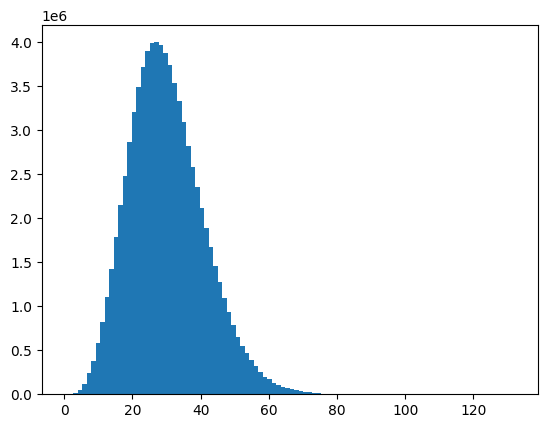

In [5]:
from matplotlib.pyplot import hist
hist(distances, bins = 100)

In [ ]:
sorted(distances)

# Write a reward function

In [10]:
import json
with open('/content/disease_to_hpo.json', 'r') as f:
    data = json.load(f)

In [11]:
lens = []
for k, v in data.items():
    lens.append(len(v))
np.mean(lens)

21.369196815638055

(array([1.137e+03, 1.042e+03, 9.610e+02, 8.510e+02, 7.310e+02, 6.620e+02,
        7.050e+02, 6.160e+02, 5.670e+02, 5.410e+02, 7.030e+02, 4.680e+02,
        4.190e+02, 3.800e+02, 3.030e+02, 2.610e+02, 2.530e+02, 2.090e+02,
        2.100e+02, 1.940e+02, 2.190e+02, 1.290e+02, 1.270e+02, 1.160e+02,
        1.010e+02, 8.600e+01, 5.200e+01, 6.500e+01, 5.700e+01, 5.400e+01,
        7.600e+01, 4.800e+01, 3.300e+01, 4.100e+01, 2.300e+01, 2.000e+01,
        2.300e+01, 2.100e+01, 2.300e+01, 1.200e+01, 2.000e+01, 9.000e+00,
        1.300e+01, 1.500e+01, 8.000e+00, 5.000e+00, 4.000e+00, 6.000e+00,
        1.000e+00, 5.000e+00, 1.300e+01, 2.000e+00, 2.000e+00, 5.000e+00,
        2.000e+00, 6.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

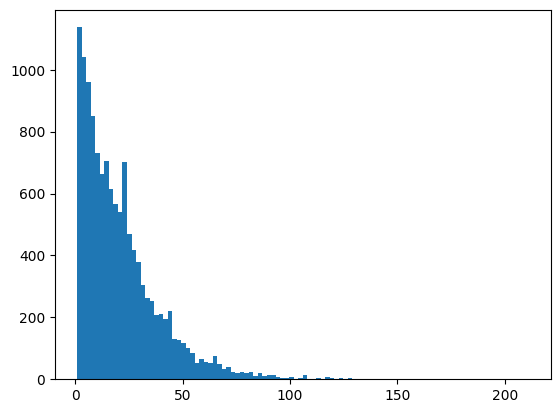

In [13]:
plt.hist(lens, bins = 100)

In [17]:
# len(lens)//2
sorted(lens)[len(lens)//2]

16

In [21]:
class RewardFn():
    '''
     -alpha(t) * l2_distance

    where alpha(t) = α_base + α_scale × (t / t_max)
    '''
    def __init__(self, max_steps = 22, threshold = 0.5):
        self.max_steps = max_steps
        self.alpha_base = 0.01
        self.alpha_scale = 1.
        self.threshold = threshold


    def calculate_reward(emb_hat, emb, t):
        distance = torch.dist(emb_hat, emb, p = 2)

        done = distance < self.threshold
        alpha = self.alpha_base + self.alpha_scale * (t / self.max_steps)
        reward = -alpha * distance
        return reward, done

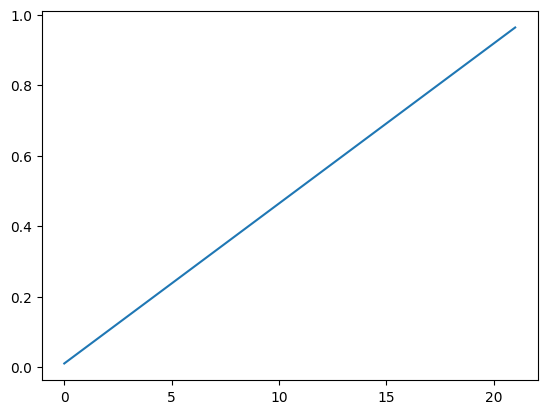

In [27]:
max_steps = 22
alpha_base = 0.01
alpha_scale = 1.

phs = []
for t in range(max_steps):
    alpha = alpha_base + alpha_scale * (t / max_steps)
    phs.append(alpha)

plt.plot(phs)

# Implement a POC on 10 to 20 Diseases

In [7]:
import torch
import pickle
import random
import json
import numpy as np

from einops import rearrange
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from matplotlib import pyplot as plt

In [17]:
# Lets first create a dataset
# Actor Network and Critic Network - Symptom and Disease

class POCDS(Dataset):
    def __init__(self, data_dict, tokenizer, Y_values, Y_embeddings):
        self.data = data_dict

        self.X = list(data_dict.values())
        self.Y = list(data_dict.keys())
        self.Y_values = Y_values
        self.Y_embeddings = Y_embeddings

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        x = self.X[idx]
        y = self.Y[idx]

        random.shuffle(x)

        if len(x) >= self.tokenizer.max_len - 1:
            x = x[:self.tokenizer.max_len - 1]

        y_val = self.Y_values[y]
        y_emb = self.Y_embeddings[y_val]

        tokens, mask = self.tokenizer.tokenize(x)
        return (tokens, mask), y_emb

In [18]:
with open('/content/drive/MyDrive/hrd_hack/ds_test.pkl', 'rb') as f:
    original_ds = pickle.load(f)

disease_embs = torch.load('/content/drive/MyDrive/hrd_hack/disease_embs.pt')
disease_embs = disease_embs.detach().cpu()

with open('/content/drive/MyDrive/hrd_hack/disease_to_hpo_with_parents.json', 'r') as f:
    data = json.load(f)

new_data = {}
keys = list(data.keys())
for i in range(100):
    new_data[keys[i]] = data[keys[i]]

tokenizer = original_ds.tokenizer
dataset = POCDS(new_data, tokenizer, original_ds.Y_values, disease_embs)

dataloader = DataLoader(dataset, batch_size = 100, shuffle = True)
x, y = next(iter(dataloader))

x[0].shape, x[1].shape, y.shape

<ipython-input-18-32139f6986e8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  disease_embs = torch.load('/content/drive/MyDrive/hrd_hack/disease_embs.pt')


(torch.Size([100, 256]), torch.Size([100, 256]), torch.Size([100, 512]))

In [19]:
class POCActor(nn.Module):
    def __init__(self, vocab_size, emb_dim = 512, n_classes = 12687, n_layers = 8, n_heads = 16):

        super().__init__()

        self.n_classes = n_classes
        self.n_layers = n_layers
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)
        self.transformers = nn.ModuleList([EncoderLayer(d_model = emb_dim, nhead = n_heads) for _ in range(n_layers)])

        self.final_norm = nn.LayerNorm(emb_dim)

        self.emb_transform_mean = nn.Sequential(
            nn.Linear(emb_dim, 1024),
            nn.GELU(approximate = 'tanh'),
            nn.Linear(1024, 512)
        )
        self.emb_transform_log_std = nn.Sequential(
            nn.Linear(emb_dim, 1024),
            nn.GELU(approximate = 'tanh'),
            nn.Linear(1024, 512)
        )

    def load_backbone(self, path = './drive/MyDrive/hrd_hack/model_checkpoint_epoch_99.pt'):
        checkpoint = torch.load(path, map_location = 'cpu')['model_state_dict']
        self_state_dict = self.state_dict()
        for k, v in checkpoint.items():
            if k in self_state_dict:
                if v.shape == self_state_dict[k].shape:
                    self_state_dict[k].copy_(v)

    def adjust_log_std(self, log_std):
        log_std_min, log_std_max = (-5, 2)  # From SpinUp / Denis Yarats
        return log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)

    def forward(self, x, mask):
        x = self.embedding(x) # (b, s, e)
        x = self.norm(x) # (b, s, e)
        mask = mask.bool()
        for transformer in self.transformers:
            x = transformer(x, mask)

        x = x[:, 0, :].squeeze() # (b, s, e) -> (b, e)

        x = self.final_norm(x).squeeze() # (b, e)

        mean = self.emb_transform_mean(x) # (b, e) -> (b, e)

        log_std = self.emb_transform_log_std(x) # (b, e) -> (b, e)
        log_std = torch.tanh(log_std)
        return mean, self.adjust_log_std(log_std)

    def get_action(self, x, mask):
        mean, log_std = self.forward(x, mask)
        std = torch.exp(log_std)
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()
        log_prob = normal.log_prob(x_t)
        return x_t, log_prob

class POCCritic(nn.Module):
    def __init__(self, vocab_size, emb_dim = 512, n_classes = 12687, n_layers = 8, n_heads = 16):

        super().__init__()

        self.n_classes = n_classes
        self.n_layers = n_layers
        self.n_heads = n_heads

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.disease_transform = nn.Sequential(
            nn.Linear(emb_dim, 1024),
            nn.GELU(approximate = 'tanh'),
            nn.Linear(1024, 512)
        )

        self.norm = nn.LayerNorm(emb_dim)
        self.transformers = nn.ModuleList([EncoderLayer(d_model = emb_dim, nhead = n_heads) for _ in range(n_layers)])
        self.final_norm = nn.LayerNorm(emb_dim)
        self.q_value = nn.Sequential(
            nn.Linear(emb_dim, 1024),
            nn.GELU(approximate = 'tanh'),
            nn.Linear(1024, 1)
        )

    def forward(self, x, mask, d_emb):
        # breakpoint()

        x = self.embedding(x) # (b, s, e)

        d_emb = self.disease_transform(d_emb) # (b, e)
        d_emb = d_emb.unsqueeze(1) # (b, s + 1, e)
        d_emb_mask = torch.ones(x.shape[0], 1)

        mask = torch.cat([mask, d_emb_mask], dim = -1)# (b, s+1, 1)
        x = torch.cat([x, d_emb], dim = 1)

        x = self.norm(x) # (b, s+1, e)
        mask = mask.bool()
        for transformer in self.transformers:
            x = transformer(x, mask)

        x = x[:, 0, :].squeeze() # (b, s, e) -> (b, e)
        x = self.final_norm(x)
        return self.q_value(x)

In [12]:
actor = POCActor(len(tokenizer.key_value), n_layers = 6)
critic = POCCritic(len(tokenizer.key_value), n_layers = 2)
actor.load_backbone()

<ipython-input-11-99d97d0369fa>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location = 'cpu')['model_state_dict']


In [93]:
# TODO

class ReplayMemoryBuffer:

    '''
    stores T - current time step
    State - Current X
    All X - Remaining X
    '''
    def __init__(self, phenos: list[list], embs: torch.Tensor,  tokenizer: Tokenizer, max_t = 50):
        import copy

        self.X = copy.deepcopy(phenos)
        self.Y = embs

        self.state_x = None
        self.max_t = max_t
        self.tokenizer = tokenizer

    def get_sample(self):

        for phenotypes, present_state in zip(self.X, self.state_x):
            if len(phenotypes) > 0:
                random.shuffle(phenotypes)
                present_state.append(phenotypes.pop(0))
            else:
                present_state.append('PAD_KEY')
        breakpoint()
        tokenized_state_x = []
        tokenized_state_mask = []

        for state in self.state_x:
            state_tokenized, state_mask = self.tokenizer.tokenize(state)
            tokenized_state_x.append(state_tokenized)
            tokenized_state_mask.append(state_mask)

        tokenized_state_x = torch.stack(tokenized_state_x)
        tokenized_state_mask = torch.stack(tokenized_state_mask)
        return (self.t, tokenized_state_x, tokenized_state_mask), y

    def get_next(self):

        if hasattr(self, 't') and self.t > 0:
            self.t += 1
        else:
            self.t = 0
            self.state_x = [[] for _ in range(len(self.X))]

        eps_done = self.t > self.max_t
        (current_t, tokenized_state_x, tokenized_state_mask), y = self.get_sample()
        return eps_done, (current_t, tokenized_state_x, tokenized_state_mask), y



In [98]:
y_values = original_ds.Y_values
diseases = list(new_data.keys())
disease_ids = [y_values[disease] for disease in diseases]
poc_disease_embs = disease_embs[disease_ids]

In [94]:
with open('/content/drive/MyDrive/hrd_hack/disease_to_hpo_with_parents.json', 'r') as f:
    data = json.load(f)

new_data = {}
keys = list(data.keys())
for i in range(100):
    new_data[keys[i]] = data[keys[i]]

poc_phenotypes = list(new_data.values())

In [95]:
tokenizer = original_ds.tokenizer
replay_buffer = ReplayMemoryBuffer(poc_phenotypes, poc_disease_embs, tokenizer)

In [96]:
eps_done, (current_t, tokenized_state_x, tokenized_state_mask), y = replay_buffer.get_next()

> <ipython-input-93-3741c8c2dcb0>(29)get_sample()
     27                 present_state.append('PAD_KEY')
     28         breakpoint()
---> 29         tokenized_state_x = []
     30         tokenized_state_mask = []
     31 

ipdb> self.state_X
*** AttributeError: 'ReplayMemoryBuffer' object has no attribute 'state_X'
ipdb> self.state_x
[['HP:0020219'], ['HP:0000707'], ['HP:0002795'], ['HP:0000664'], ['HP:0001995'], ['HP:0005110'], ['HP:0000001'], ['HP:0005607'], ['HP:0001892'], ['HP:0011443'], ['HP:0001714'], ['HP:4000074'], ['HP:0011446'], ['HP:0040070'], ['HP:0012880'], ['HP:0200127'], ['HP:0030084'], ['HP:0025031'], ['HP:0030012'], ['HP:0000366'], ['HP:0000523'], ['HP:0410042'], ['HP:0000001'], ['HP:0001510'], ['HP:0410042'], ['HP:0000007'], ['HP:0004377'], ['HP:0004328'], ['HP:0031797'], ['HP:0031704'], ['HP:0000504'], ['HP:0011675'], ['HP:0000924'], ['HP:0009830'], ['HP:0003674'], ['HP:0002014'], ['HP:0100834'], ['HP:0000805'], ['HP:0002715'], ['HP:0002321'], ['HP:0000609'], ['HP

In [86]:
tokenized_state_x.shape, tokenized_state_mask.shape

(torch.Size([100, 256]), torch.Size([100, 256]))

In [97]:
eps_done, (current_t, tokenized_state_x, tokenized_state_mask), y = replay_buffer.get_next()
eps_done, (current_t, tokenized_state_x, tokenized_state_mask), y = replay_buffer.get_next()

> <ipython-input-93-3741c8c2dcb0>(29)get_sample()
     27                 present_state.append('PAD_KEY')
     28         breakpoint()
---> 29         tokenized_state_x = []
     30         tokenized_state_mask = []
     31 

ipdb> self.state_x
[['HP:0000001'], ['HP:0001878'], ['HP:0010978'], ['HP:0000309'], ['HP:0001944'], ['HP:0001626'], ['HP:0001939'], ['HP:0002783'], ['HP:0000005'], ['HP:0031826'], ['HP:0003596'], ['HP:5200044'], ['HP:0100538'], ['HP:0030084'], ['HP:0000055'], ['HP:0000001'], ['HP:0009774'], ['HP:0100834'], ['HP:0000202'], ['HP:0006493'], ['HP:0031797'], ['HP:0001438'], ['HP:0000163'], ['HP:0002977'], ['HP:0040134'], ['HP:0000504'], ['HP:0002665'], ['HP:0000005'], ['HP:0000613'], ['HP:0000365'], ['HP:0002423'], ['HP:0012251'], ['HP:0031797'], ['HP:0001939'], ['HP:0002270'], ['HP:0002037'], ['HP:0001909'], ['HP:0012591'], ['HP:0001252'], ['HP:0001751'], ['HP:0100543'], ['HP:0001612'], ['HP:0011025'], ['HP:0000662'], ['HP:0025031'], ['HP:0001321'], ['HP:0011446'], ['

In [89]:
tokenized_state_x[0], tokenized_state_mask[0]

(tensor([   0, 4615,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [ ]:
class Agent:
    '''
    Twin Critic
    Actor

    Optimization step
    '''

In [100]:
x = [[], []]
for i in x:
    i.append(1)
for i in x:
    i.append(1)

x

[[1, 1], [1, 1]]

# Scope it out to the entire dataset